In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
inspector = inspect(engine)

In [13]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [16]:
#Latest Date
results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
first_date = list(np.ravel(results))
first_date[0]

'2017-08-23'

In [17]:
# Latest Date
results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
first_date = list(np.ravel(results))

latest_year = int(first_date[0][:4])
latest_month = int(first_date[0][5:7])
latest_day = int(first_date[0][-2:])
latest_date = dt.date(latest_year, latest_month, latest_day)

print(latest_date)

2017-08-23


In [18]:
# Calculate the date 1 year ago from the last data point in the database
previous_year = dt.date(latest_year - 1, latest_month, latest_day)
print(previous_year)

2016-08-23


In [19]:
# Perform a query to retrieve the data and precipitation scores
prcp_last_12_months = session.query(Measurement.date, Measurement.prcp ).\
    filter(func.strftime(Measurement.date) >= previous_year).all()

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_last_12_months_df = pd.DataFrame(prcp_last_12_months, columns=['date', 'precipitation'])
prcp_last_12_months_df.set_index('date', inplace=True)
prcp_last_12_months_df

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


In [21]:
# Sort the dataframe by date
prcp_last_12_months_df.sort_values(by=['date'], inplace=True)

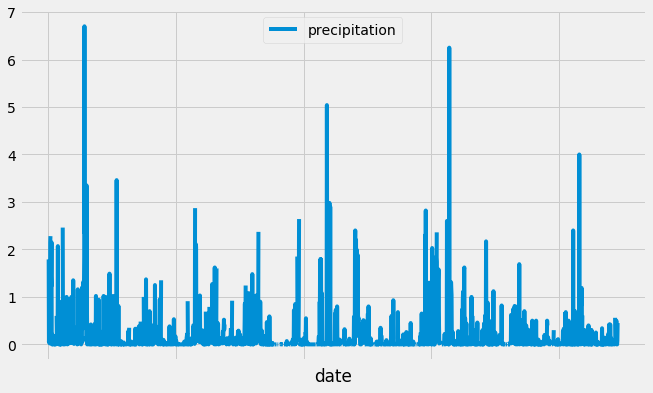

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_last_12_months_df.plot.line(figsize=(10,6))
plt.legend(loc="upper center")
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_last_12_months_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"Number of stations available in this dataset: {number_stations} ")

Number of stations available in this dataset: 9 


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),  
       func.avg(Measurement.tobs)]

results = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
temp = list(np.ravel(results))

print(f"The most active station is: {temp[0]}, temperature lowest: {temp[1]}, max: {temp[2]}, average: {temp[3]}")

The most active station is: USC00519281, temperature lowest: 54.0, max: 85.0, average: 71.66378066378067


In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [124]:
# Latest Date
first_date = session.query(Measurement.date).\
    filter(Measurement.station == "USC00519281").order_by(Measurement.date.desc()).first()

latest_year = int(first_date[0][:4])
latest_month = int(first_date[0][5:7])
latest_day = int(first_date[0][-2:])
latest_date = dt.date(latest_year, latest_month, latest_day)

print(latest_date)

2017-08-18


In [125]:
# Calculate the date 1 year ago from the last data point in the database
previous_year = dt.date(latest_year - 1, latest_month, latest_day)
print(previous_year)

2016-08-18


In [126]:
# Perform a query to retrieve the data and temperature scores
tobs_last_12_months = session.query(Measurement.tobs).\
    filter(func.strftime(Measurement.date) >= previous_year, Measurement.station == "USC00519281").all()

In [127]:
# Save the query results as a Pandas DataFrame and set the index to the date column
tobs_last_12_months_df = pd.DataFrame(tobs_last_12_months, columns=['tobs'])


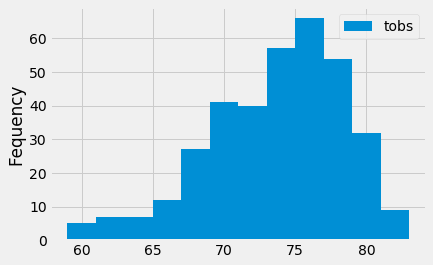

In [128]:

plt.hist(tobs_last_12_months_df['tobs'], bins=12, label='label')
plt.ylabel('Fequency')
labels= ['tobs']
plt.legend(labels)
plt.show()

In [129]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [130]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

results = calc_temps(previous_year, latest_date)
trip_temps = list(np.ravel(results))
print(trip_temps)

[58.0, 74.59875167186803, 87.0]


# Optional: Other Recommended Analyses

In [131]:
peak_to_peak = trip_temps[2] - trip_temps[0]
average_temp = trip_temps[1]
width = .15

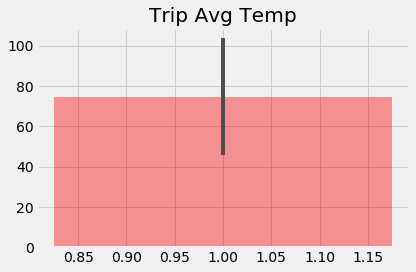

In [132]:
fig, ax = plt.subplots()

bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(1, average_temp, bar_width,
                alpha=opacity, color='red',
                yerr=peak_to_peak, error_kw=error_config)

ax.set_title('Trip Avg Temp')

fig.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


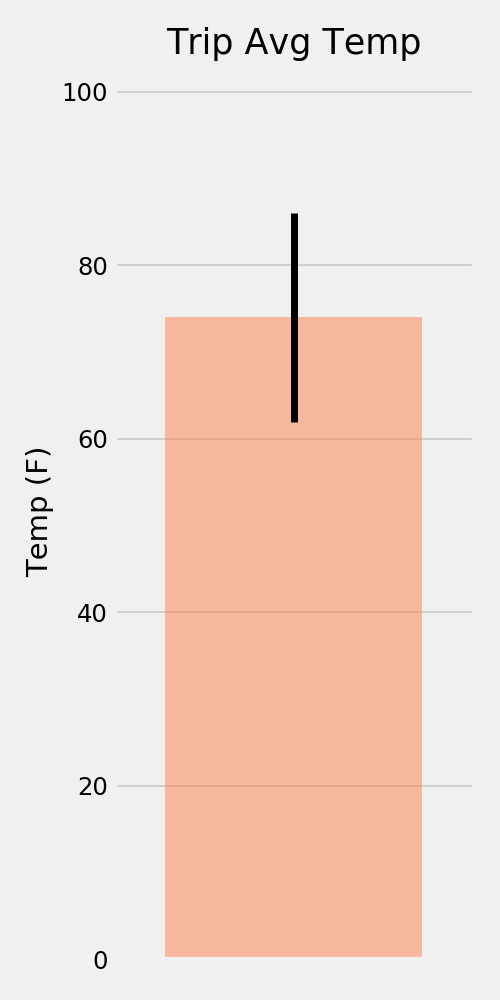

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


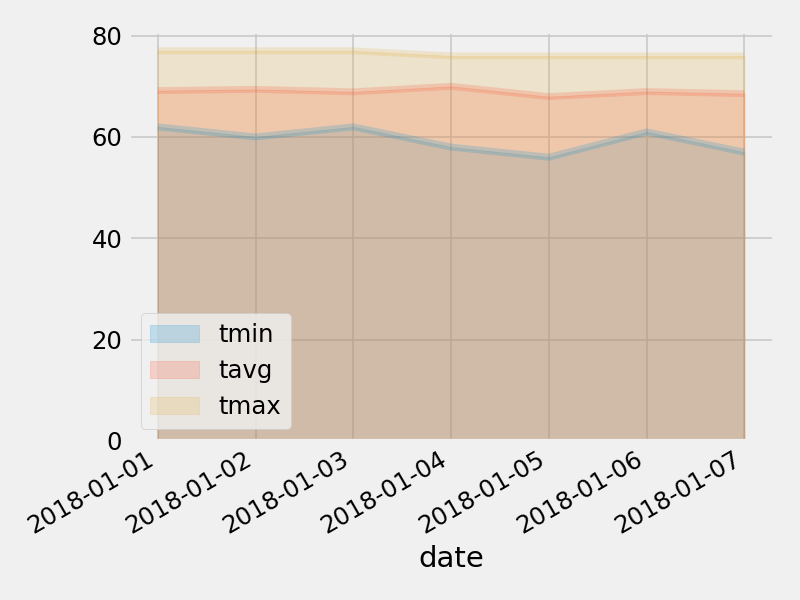

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
